# Make_Figure_PTEN_1C:  Uniqueness of trans effect

Create a bar/dumbell plot to look at number of genes that are significant in one or multiple cancers. 

Imports.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import plot_utils as p
root = R'~\Github\WhenMutationsDontMatter\PTEN\Figure_2\csv'

# Step 1: Create sig column 

Sig column shows all cancers with a sig comparison for the specific gene. First, get a df with p-values and differential expression for all proteins in all cancers.

In [ ]:
all_df = pd.read_csv(root+R"\all_pval_all_proteins.csv")

In [35]:
for index, row in all_df.iterrows():
    cancer_names = ['Gbm','Hnscc','Luad','Lscc','Brca','Ov','En','Colon']
    label = []
    for cancer in cancer_names:
        if row[cancer+'_P_Value'] < 0.05:
            label.append(str(cancer))
    labeled = '_'.join(label)
    all_df.loc[index,'sig'] = str(labeled)
all_df[['Proteomics', 'sig']].head()

,Proteomics,sig
0,ARMH3,Gbm_Hnscc_En
134,RAB8B,Gbm_Hnscc_Luad
749,CAD,Gbm_Hnscc_En
1311,RCSD1,Gbm_Hnscc_Luad
1481,CORO1A,Gbm_Hnscc_Luad


# Step 2: Keep genes significant in at least one cancer

First create the numSig column that counts the number of cancers with a significant test for the specific gene. 

In [9]:
def Pvalue_sig(row):
    numSig = 0

    for item in row:
        if pd.isnull(item):
            continue
        if item < 0.05: 
            numSig += 1
            
    return numSig

In [32]:
all_df["Num_sig"] = all_df.loc[:,["Gbm_P_Value","Hnscc_P_Value","Luad_P_Value","Lscc_P_Value", "Brca_P_Value","Ov_P_Value","En_P_Value","Colon_P_Value"]].apply(Pvalue_sig, axis = 1)
all_df = all_df.sort_values(by=['Num_sig'],ascending=False)

#Keep trans genes that are significant in atleast 1 cancer. 
all_df1 = all_df[all_df['Num_sig'].isin([1,2,3,4,5,6,7,8])]
all_df1.head()


,Proteomics,Gbm_P_Value,Gbm_Median,Hnscc_P_Value,Hnscc_Median,Luad_P_Value,Luad_Median,Lscc_P_Value,Lscc_Median,Brca_P_Value,Brca_Median,Ov_P_Value,Ov_Median,En_P_Value,En_Median,Colon_P_Value,Colon_Median,sig,Num_sig
0,ARMH3,5.766739e-07,-0.405134,0.024047,-0.135941,0.222235,-0.37845,0.906857,-0.27970,NaN,NaN,NaN,NaN,0.034811,0.1503,NaN,NaN,Gbm_Hnscc_En,3
134,RAB8B,1.608872e-03,-0.446976,0.023883,-0.376723,0.027098,-0.75010,0.999848,0.21995,0.923055,0.03295,0.991931,-0.010445,0.972666,0.3410,0.931817,0.00005,Gbm_Hnscc_Luad,3
749,CAD,1.129430e-02,0.346369,0.011810,0.367409,0.995158,0.04890,0.999848,0.23650,0.421177,0.51975,0.985704,-0.111223,0.018280,-0.2692,0.854580,0.03950,Gbm_Hnscc_En,3
1311,RCSD1,2.685052e-02,-0.411353,0.016000,-0.486965,0.042108,-0.89900,0.999848,0.00705,0.906008,-0.01750,0.985704,0.306776,0.508016,-0.0125,0.901656,0.01400,Gbm_Hnscc_Luad,3
1481,CORO1A,3.343957e-02,-0.557922,0.033231,-0.454549,0.043364,-1.26555,0.999848,-0.12010,0.736200,-0.44910,0.985704,0.110334,0.640847,-0.2960,0.901656,-0.11410,Gbm_Hnscc_Luad,3


# Step 3: Get df with total counts of significant genes

Get count of sig genes for each unique label of a single cancer or multiple cancers in the sig column. 

In [33]:
# Count the number of unique values in sig
vc = all_df1['sig'].value_counts()
df = vc.to_frame()

# Add cancers with no significant genes.
no_sig = {'Colon': 0, 'Brca': 0, 'Lscc': 0, 'Ov': 0}
ns_df = pd.DataFrame.from_dict(no_sig, orient = 'index', columns=['sig'])

# Append
both = df.append(ns_df)
both = both.reset_index()
both = both.rename(columns = {'index': 'cancer'})

# Reindex to keep single cancers together
s = [0,1,2,5,19,18,17,16,3,4,6,7,8,9,10,11,12,13,14,15]
both = both.reindex(s)
both

,sig
Gbm,1622
Hnscc,353
En,275
Gbm_Hnscc,128
Gbm_En,89
Luad,48
Hnscc_En,29
Hnscc_Luad,24
Gbm_Luad,22
Gbm_Hnscc_En,21


# Step 4: Create bar and dumbell plot

First, create a df with 3 y-axis points for the scatterplots. Values represent where the cancer label is on the y-axis. (Gbm: 7, Hnscc: 6, En: 5, Luad: 4, Ov: 3, Lscc: 2, Brca: 1, Colon: 0) For a single cancer all 3 points are teh same. For three cancers, each y-axis point represents a different cancer. NOTE: PTEN contains genes significant in up to three cancers.


In [27]:
# Create df with location of cancer points 
# Order of dictionary keys follows order of both['cancer'] (x-axis of bar plot)
y1 = {'Gbm': 7, 'Hnscc': 6, 'En': 5, 'Luad': 4, 'Ov': 3, 'Lscc': 2, 'Brca': 1, 'Colon': 0,
      'Gbm_Hnscc': 7, 'Gbm_En': 7, 'Hnscc_En': 6, 'Hnscc_Luad': 6, 'Gbm_Luad': 7, 
      'Gbm_Hnscc_En': 7, 'Gbm_Hnscc_Luad': 7, 'Gbm_Luad_Ov': 7, 'Gbm_Luad_En': 7, 'Gbm_Lscc': 7,
      'Gbm_Hnscc_Lscc': 7, 'Luad_Lscc': 4}

y2= {'Gbm': 7, 'Hnscc': 6, 'En': 5, 'Luad': 4, 'Ov': 3, 'Lscc': 2, 'Brca': 1, 'Colon': 0,
     'Gbm_Hnscc': 6, 'Gbm_En': 5, 'Hnscc_En': 5, 'Hnscc_Luad': 4, 'Gbm_Luad': 4, 
     'Gbm_Hnscc_En': 6, 'Gbm_Hnscc_Luad': 6, 'Gbm_Luad_Ov': 4, 'Gbm_Luad_En': 4, 'Gbm_Lscc': 2,
      'Gbm_Hnscc_Lscc': 6, 'Luad_Lscc': 2}

y3= {'Gbm': 7, 'Hnscc': 6, 'En': 5, 'Luad': 4, 'Ov': 3, 'Lscc': 2, 'Brca': 1, 'Colon': 0,
     'Gbm_Hnscc': 6, 'Gbm_En': 5, 'Hnscc_En': 5, 'Hnscc_Luad': 4, 'Gbm_Luad': 4, 
     'Gbm_Hnscc_En': 5, 'Gbm_Hnscc_Luad': 4, 'Gbm_Luad_Ov': 3, 'Gbm_Luad_En': 5, 'Gbm_Lscc': 2,
      'Gbm_Hnscc_Lscc': 2, 'Luad_Lscc': 2}
        
# Create dfs for each y-axis point
y1_df = pd.DataFrame.from_dict(y1, orient = 'index', columns=['y1'])
y2_df = pd.DataFrame.from_dict(y2, orient = 'index', columns=['y2'])
y3_df = pd.DataFrame.from_dict(y3, orient = 'index', columns=['y3'])

# Join dfs
ordered_df = y1_df.join(y2_df)
ordered_df = ordered_df.join(y3_df)
ordered_df

,y1,y2,y3
Gbm,7,7,7
Hnscc,6,6,6
En,5,5,5
Luad,4,4,4
Ov,3,3,3
Lscc,2,2,2
Brca,1,1,1
Colon,0,0,0
Gbm_Hnscc,7,6,6
Gbm_En,7,5,5


Create bar plot and dumbell plot. x-axis of dumbell plot follows order of bar plot. 

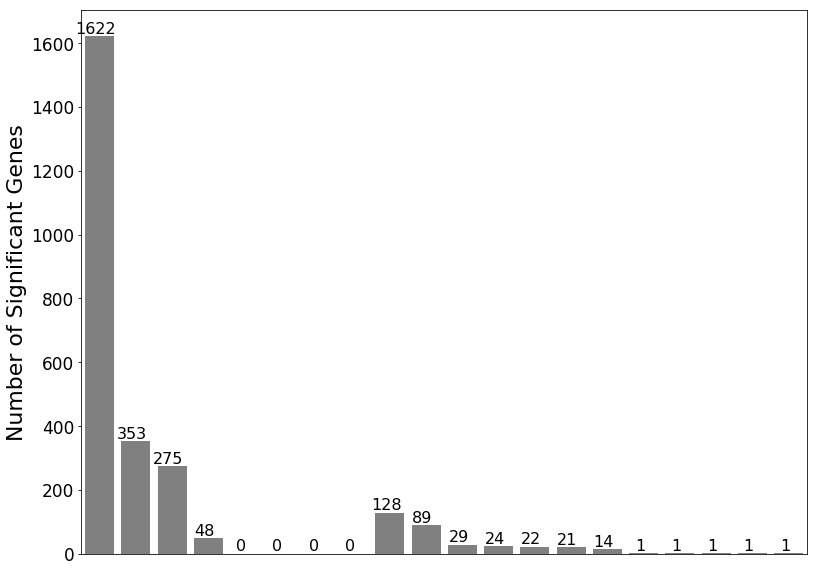

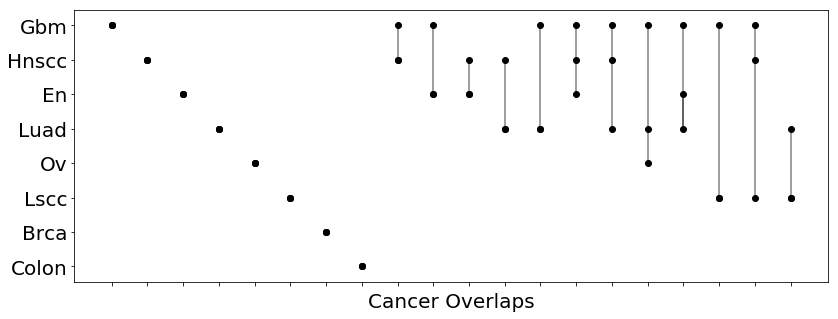

In [49]:
# Bar Plot
plt.figure(figsize=(13,10))
o = sns.barplot(x=both['cancer'], y=both['sig'], data=both, color='grey')
plt.setp(o.get_xticklabels(),rotation=90)

# Annotate count of sig genes above each bar
for p in o.patches:
    o.annotate('{:.0f}'.format(p.get_height()), xy = (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom', color= 'black',size = 16)

o.set_xlabel('', size = 17)
o.set_ylabel('Number of Significant Genes', size = 22)
o.get_xaxis().set_visible(False) # Hide x-axis
o.yaxis.set_tick_params(labelsize=17)


# Dumbell Plot
# Create vertical dumbell plot using scatterplots
plt.rcParams.update({'font.size': 20})
d = plt.figure(figsize=(13.5,5))
my_range=range(1,len(ordered_df.index)+1) #range count for x axis num
d = plt.vlines(x=my_range, ymin=ordered_df['y1'], ymax=ordered_df['y2'], color='black', alpha=0.5) #vertical lines
d = plt.vlines(x=my_range, ymin=ordered_df['y2'], ymax=ordered_df['y3'], color='black', alpha=0.5)
d = plt.scatter(my_range, ordered_df['y1'], color='black', alpha=1) #plots first point
d = plt.scatter(my_range, ordered_df['y2'], color='black', alpha=1) # plots second point
d = plt.scatter(my_range, ordered_df['y3'], color='black', alpha=1) # plots third point

# Add title and axis names
labels = list(ordered_df.index[:8]) # label 8 single cancer names y axis
labels.reverse()
plt.xticks(my_range, []) #none for x axis
plt.yticks(range(0,8), labels) # single cancer names
#plt.ylabel('Cancer')
plt.xlabel('Cancer Overlaps')

o.figure.savefig("PTEN_Fig_1C_barplot.png", dpi = 300)
d.figure.savefig("PTEN_Fig_1C_dumbell.png", dpi = 300)

# Get total number of genes significant in one cancer

In [31]:
#Keep trans genes that are significant in at least 1 cancer. 
at_least_one = all_df[all_df['Num_sig'].isin([1,2,3,4,5,6,7,8])]
print('Significant genes in at least one cancer:', len(at_least_one.Proteomics.unique()))

Significant genes in at least one cancer: 2630


In [37]:
# check 3 lscc sig genes
l = all_df.loc[all_df['Lscc_P_Value'] < 0.05]
l[['Proteomics', 'Lscc_P_Value', 'Gbm_P_Value', 'Hnscc_P_Value', 'Luad_P_Value','sig']]

,Proteomics,Lscc_P_Value,Gbm_P_Value,Hnscc_P_Value,Luad_P_Value,sig
420,ATAD1,0.000006,0.005723,0.031703,0.195221,Gbm_Hnscc_Lscc
48,VPS26A,0.047096,0.000622,0.932416,0.085454,Gbm_Lscc
6524,BTAF1,0.001136,0.460174,0.080719,0.012853,Luad_Lscc
